In [17]:
!pip install iterative-stratification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

CREATE SYNTHETIC LOOP DATASET

In [33]:
np.random.seed(42)
n_samples = 300


data = {
    'initial_value': np.random.randint(0, 20, n_samples),
    'increment': np.random.randint(1, 5, n_samples),
    'exit_condition': np.random.randint(30, 100, n_samples),
    'nesting_level': np.random.randint(0, 3, n_samples)
}


df = pd.DataFrame(data)


df['iteration_count'] = (df['exit_condition'] - df['initial_value']) // df['increment']


df['label_small_iter'] = (df['iteration_count'] < 10).astype(int)
df['label_nested'] = (df['nesting_level'] > 0).astype(int)

print(df.head())


   initial_value  increment  exit_condition  nesting_level  iteration_count  \
0              6          1              88              1               82   
1             19          2              48              2               14   
2             14          3              78              2               21   
3             10          2              41              1               15   
4              7          2              90              1               41   

   label_small_iter  label_nested  
0                 0             1  
1                 0             1  
2                 0             1  
3                 0             1  
4                 0             1  


EXPLORATORY DATA ANALYSIS

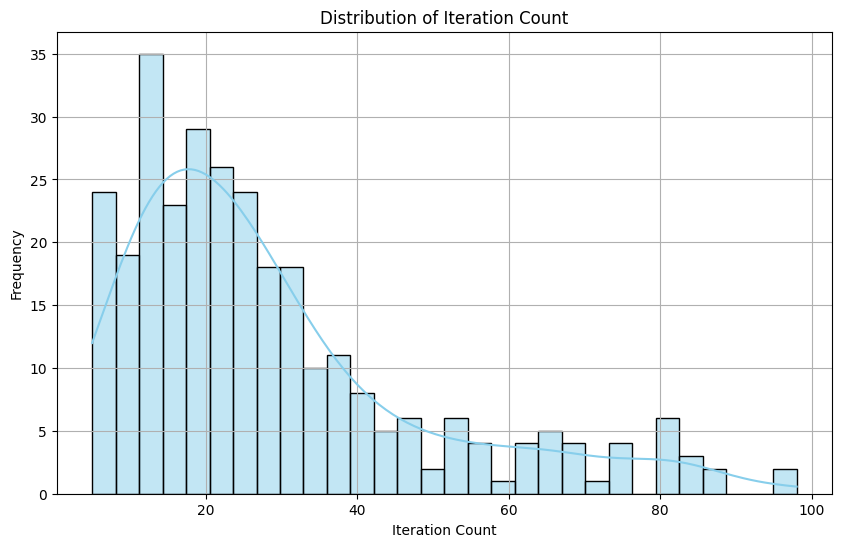

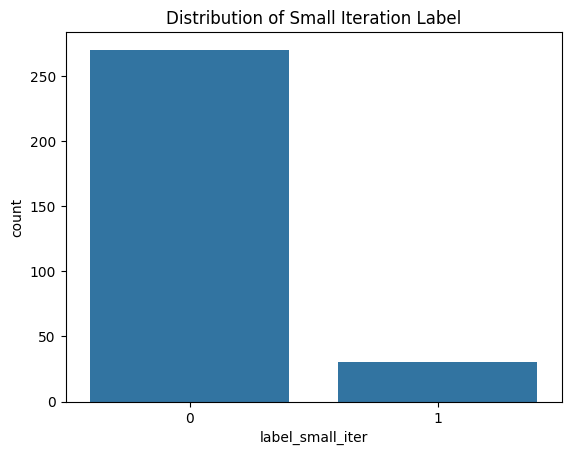

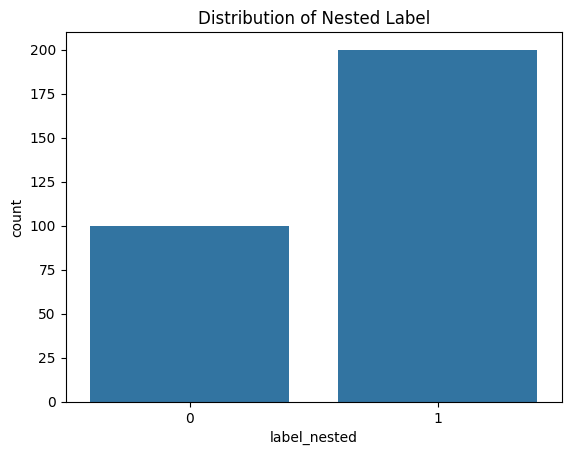

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df['iteration_count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Iteration Count')
plt.xlabel('Iteration Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

sns.countplot(x='label_small_iter', data=df)
plt.title('Distribution of Small Iteration Label')
plt.show()

sns.countplot(x='label_nested', data=df)
plt.title('Distribution of Nested Label')
plt.show()

SPLIT FEATURES AND LABELS

In [20]:
X = df[['initial_value', 'increment', 'exit_condition', 'nesting_level']].values
y = df[['label_small_iter', 'label_nested']].values

 MULTILABEL STRATIFIED K-FOLD SPLITTING

In [21]:
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
splits = list(mskf.split(X, y))
train_index, test_index = splits[0]

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

TRAIN AND EVALUATE RANDOM FOREST AND KNN MODELS

In [28]:
from sklearn.neighbors import KNeighborsClassifier

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5)
}

for model_name, model in models.items():
    print(f"\n=== {model_name} ===")
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    report = classification_report(y_test, predictions, target_names=['Small Iter', 'Nested'])
    print(report)



=== Random Forest ===
              precision    recall  f1-score   support

  Small Iter       1.00      0.50      0.67         6
      Nested       1.00      1.00      1.00        40

   micro avg       1.00      0.93      0.97        46
   macro avg       1.00      0.75      0.83        46
weighted avg       1.00      0.93      0.96        46
 samples avg       0.67      0.65      0.66        46


=== K-Nearest Neighbors ===
              precision    recall  f1-score   support

  Small Iter       1.00      0.50      0.67         6
      Nested       0.69      0.88      0.77        40

   micro avg       0.70      0.83      0.76        46
   macro avg       0.84      0.69      0.72        46
weighted avg       0.73      0.83      0.76        46
 samples avg       0.59      0.60      0.59        46



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/me

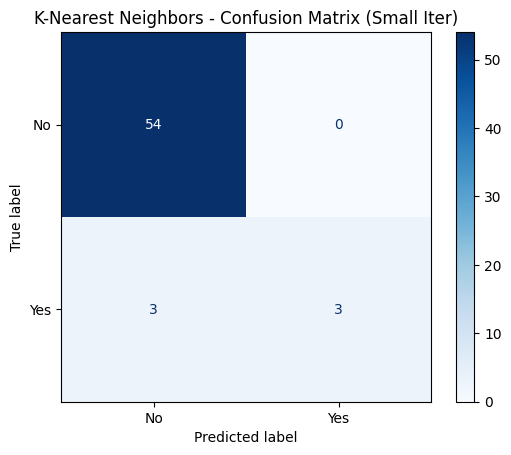

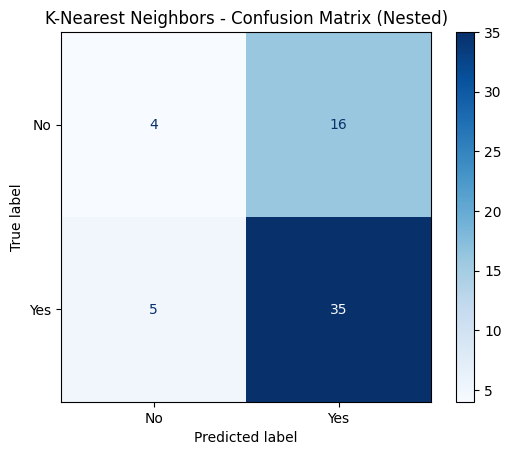

In [29]:
for i, label_name in enumerate(['Small Iter', 'Nested']):
        cm = confusion_matrix(y_test[:, i], predictions[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
        disp.plot(cmap='Blues')
        plt.title(f'{model_name} - Confusion Matrix ({label_name})')
        plt.show()


 FEATURE IMPORTANCE VISUALIZATION

/tmp/ipython-input-12-299992984.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=feature_names, palette='viridis')


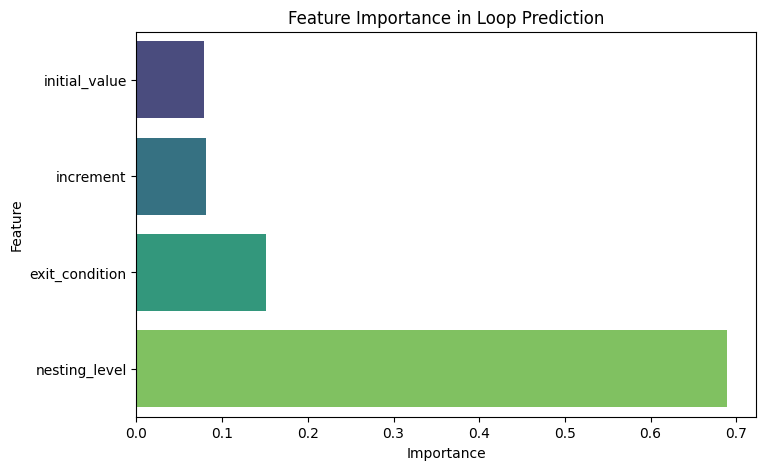

In [12]:
feature_names = ['initial_value', 'increment', 'exit_condition', 'nesting_level']
importances = model.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names, palette='viridis')
plt.title('Feature Importance in Loop Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


FEATURE IMPORTANCE FOR RANDOM FOREST

/tmp/ipython-input-30-2159150201.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='Importance', y='Feature', palette='viridis')


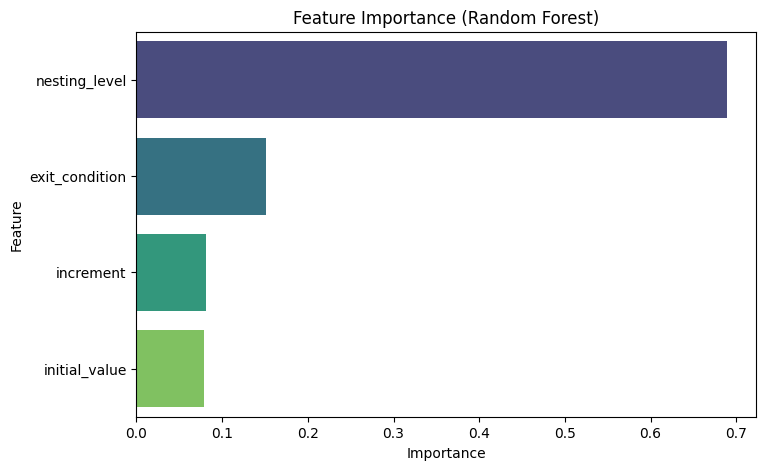

In [30]:
feature_names = ['initial_value', 'increment', 'exit_condition', 'nesting_level']
rf_importances = models['Random Forest'].feature_importances_

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=df_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Model Performance Comparison (Bar Chart)

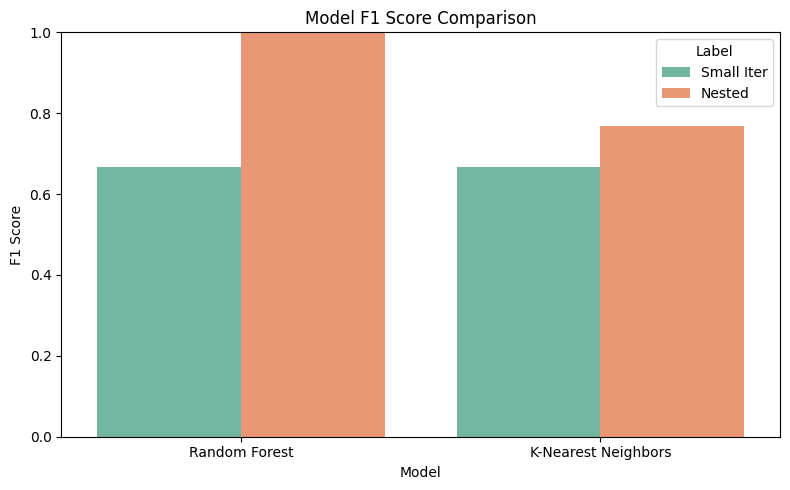

In [31]:
from sklearn.metrics import f1_score


model_scores = []

for model_name, model in models.items():
    preds = model.predict(X_test)
    f1_small = f1_score(y_test[:, 0], preds[:, 0])
    f1_nested = f1_score(y_test[:, 1], preds[:, 1])
    model_scores.append({'Model': model_name, 'Label': 'Small Iter', 'F1 Score': f1_small})
    model_scores.append({'Model': model_name, 'Label': 'Nested', 'F1 Score': f1_nested})

df_scores = pd.DataFrame(model_scores)


plt.figure(figsize=(8, 5))
sns.barplot(data=df_scores, x='Model', y='F1 Score', hue='Label', palette='Set2')
plt.title('Model F1 Score Comparison')
plt.ylim(0, 1)
plt.legend(title='Label')
plt.tight_layout()
plt.show()


Pair Plot of Features Colored by Label

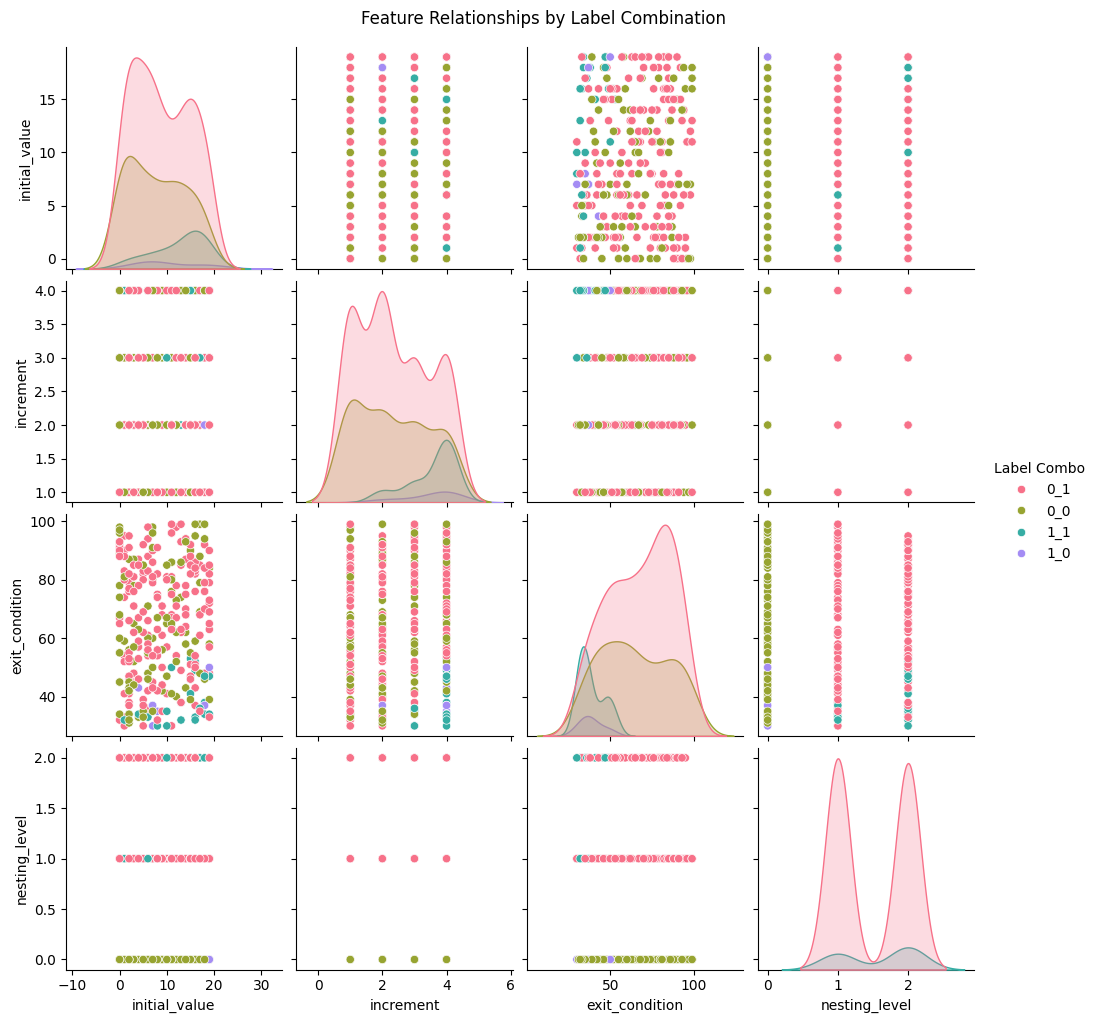

In [32]:

df_viz = df.copy()
df_viz['Label Combo'] = df_viz['label_small_iter'].astype(str) + '_' + df_viz['label_nested'].astype(str)

sns.pairplot(df_viz, vars=['initial_value', 'increment', 'exit_condition', 'nesting_level'],
             hue='Label Combo', palette='husl', diag_kind='kde')
plt.suptitle('Feature Relationships by Label Combination', y=1.02)
plt.show()


Correlation Heatmap of Features

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


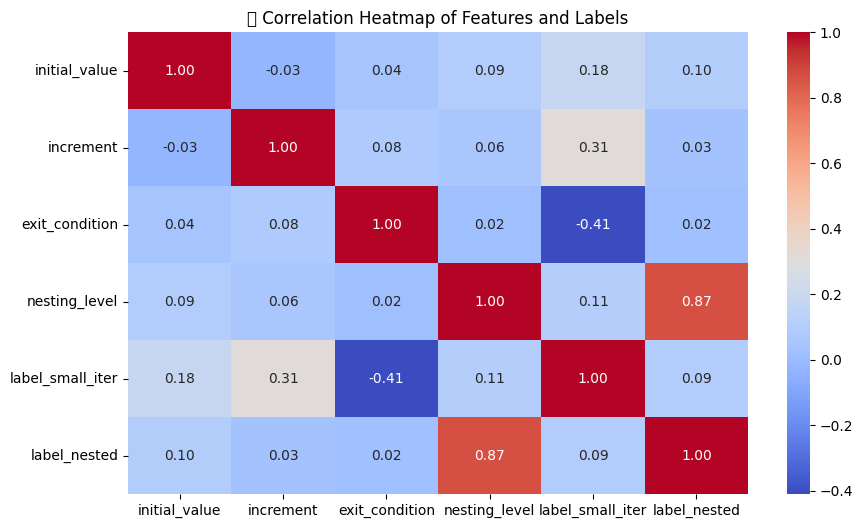

In [34]:

corr_matrix = df[['initial_value', 'increment', 'exit_condition', 'nesting_level', 'label_small_iter', 'label_nested']].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Correlation Heatmap of Features and Labels")
plt.show()
